**Part 2. AI Agent 활용 프로젝트**

- Chapter 02. 컨텍스트 품질을 보장하는 RAG

    - **📒[실습]** Clip 03. 환각 여부를 평가하는 RAG (+Web Search Agent) 🗒️

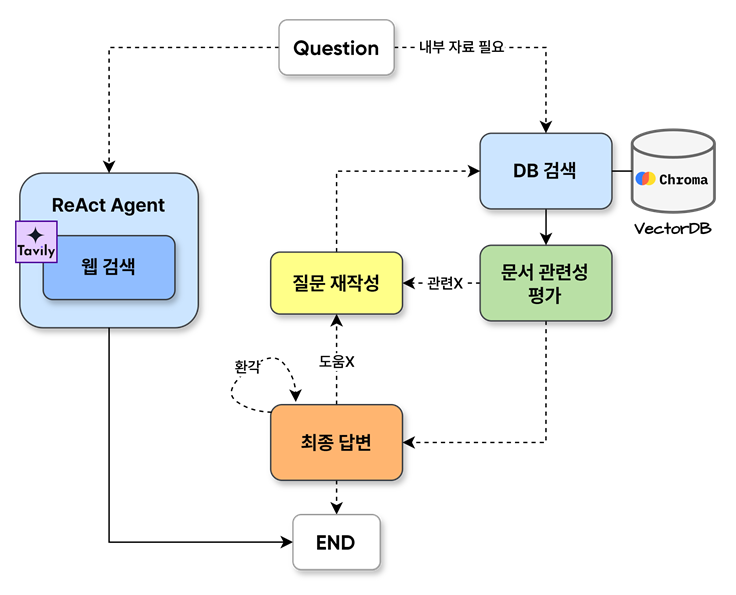

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

## 🗄️ Vector DB (문서 검색을 위한 Retriever 생성하기)

In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings

file_path = "SPRi AI Brief_4월호_산업동향_250407_F.pdf"

loader = PyPDFLoader(file_path)
pages = []

async for page in loader.alazy_load():
    pages.append(page)

text_splitter = SemanticChunker(OpenAIEmbeddings())

docs = text_splitter.split_documents(pages)

In [3]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vectorstore = Chroma.from_documents(documents=docs, embedding=OpenAIEmbeddings())

In [4]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

## 👉 Graph

In [5]:
from langgraph.graph import MessagesState


class State(MessagesState):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        document: retrieved document
    """

    question: str
    generation: str
    document: str

### Step 1. Node

#### 1) Retriever 호출을 위한 Agent 와 Retriever

In [6]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_ai_policy_april_2025",
    "Search and return information from the April 2025 AI Policy Report, including global AI policies, legal regulations, major industry updates, technical research, education trends, and government strategies related to AI development.",
)

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def agent(state: State):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.
    """
    print("##### HI ! #####")
    messages = state["messages"]
    llm_with_tools = llm.bind_tools([retriever_tool]) # , tool_choice="any"
    response = llm_with_tools.invoke(messages)
    print("response", response)

    return {"messages": [response], "question" : messages[0].content}

In [ ]:
def retrieve(state: State):
    """
    Retrieve documents
    """
    print("##### RETRIEVE #####")
    question = state["question"]

    document = retriever.invoke(question)


    return {"document": document[0].page_content, "question": question}

#### 2) 관련성 평가

In [9]:
from pydantic import BaseModel, Field

class Grade(BaseModel):
    """Binary score for relevance check."""

    binary_score: str = Field(description="Relevance score 'yes' or 'no'")

In [10]:
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate


def grade_documents(state: State):
    """
    Determines whether the retrieved document is relevant to the question.
    """

    print("##### CHECK RELEVANCE #####")

    grader = llm.with_structured_output(Grade)

    grader_prompt = ChatPromptTemplate.from_template(
        """
        You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        """
    )

    chain = grader_prompt | grader

    question = state["question"]
    print("state[messages]", state["messages"])
    
    document = state["document"]

    print("question", question)
    print("context", document)

    score = chain.invoke({"question": question, "context": document})
    print("context", document)
    grade = score.binary_score
    print("grade", grade)
    if grade == "yes":
        print("---GRADE: DOCUMENT RELEVANT---")
        return {"document": document, "question": question}
    else:
        print("---GRADE: DOCUMENT NOT RELEVANT---")
        return {"document": "", "question": question}

#### 3) 답변 생성

In [11]:
def generate(state: State):
    """
    Generate answer based on the retrieved document and the question.
    """
    print("##### GENERATE #####")
    question = state["question"]
    document = state["document"]
    print("question", question)
    print("context", document)
    prompt = hub.pull("rlm/rag-prompt")

    response = llm.invoke(
        prompt.format_messages(context=document, question=question)
    )
    print("response", response)
    return {"documents": document, "question": question, "generation": response.content, "messages": [response]}

#### 4) 질문 재작성

In [12]:
from langchain_core.messages import HumanMessage

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("##### TRANSFORM QUERY #####")
    question = state["question"]

    system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "user",
                "Here is the initial question: \n\n {question} \n Formulate an improved question In Korean. ",
            ),
        ]
    )

    question_rewriter = re_write_prompt | llm

    better_question = question_rewriter.invoke({"question": question})
    print("question", question)
    print("better_question", better_question.content)
    return {"question": better_question.content, "messages": [better_question]}


#### 5) Web Search Agent

In [13]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
web_search_agent = create_react_agent(llm, tools=[TavilySearchResults(max_results=3)])

### Step 2. Edge

#### 1) 답변 생성 여부 결정

In [14]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    """

    print("##### ASSESS GRADED DOCUMENTS #####")

    if state["document"] == "":
        print(
            "---DECISION: RETRIEVED DOCUMENT ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        print("---DECISION: GENERATE---")
        return "generate"

#### 2) 답변 평가

- 답변 해결성 평가 (답변과 질문을 비교)

In [15]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


structured_llm_grader = llm.with_structured_output(GradeAnswer)

system = """You are a grader assessing whether an answer addresses / resolves a question \n 
    If ambiguous, return no. \n
    Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("user", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader

- 환각 평가 (문서와 답변을 비교하여 팩트 체크)

In [16]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

structured_llm_grader = llm.with_structured_output(GradeHallucinations)

system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("user", "Set of facts: \n\n {document} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

- 환각 발생 : `not supported`

- 환각 X, 답변이 질문을 해결 X : `not useful`

- 환각 X, 답변이 질문을 해결 O : `useful`

In [17]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.
    """

    print("##### CHECK HALLUCINATIONS #####")
    question = state["question"]
    document = state["document"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"document": document, "generation": generation}
    )
    grade = score.binary_score

    
    if grade == "yes": # 환각 없음
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes": # 답변이 질문을 해결함
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else: # 답변이 질문을 해결하지 않음
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else: # 환각 있음
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Step 3. Graph Compile

In [18]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)

graph_builder.add_node("agent", agent)
graph_builder.add_node("web_search_agent", web_search_agent)
graph_builder.add_node("retrieve", retrieve)

graph_builder.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: "web_search_agent",
    },
)
graph_builder.add_edge(START, "agent")
graph_builder.add_edge("web_search_agent", END)

In [19]:
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_node("generate", generate)
graph_builder.add_node("transform_query", transform_query)

graph_builder.add_edge("retrieve", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
graph_builder.add_edge("transform_query", "retrieve")
graph_builder.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

graph = graph_builder.compile()

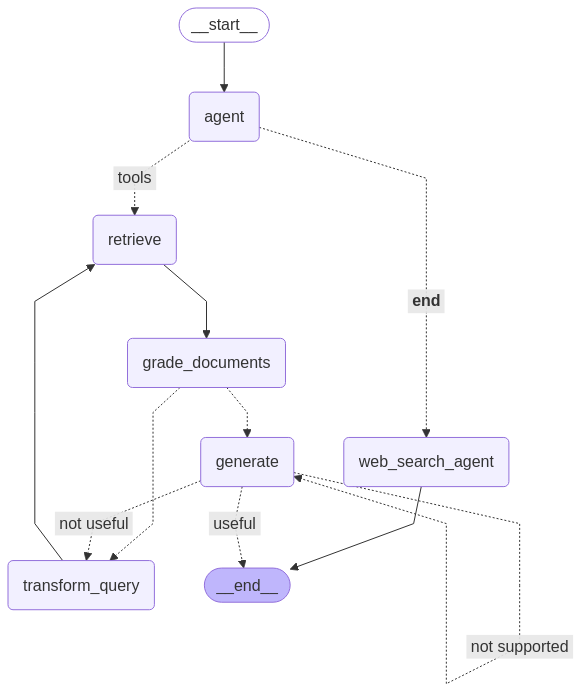

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

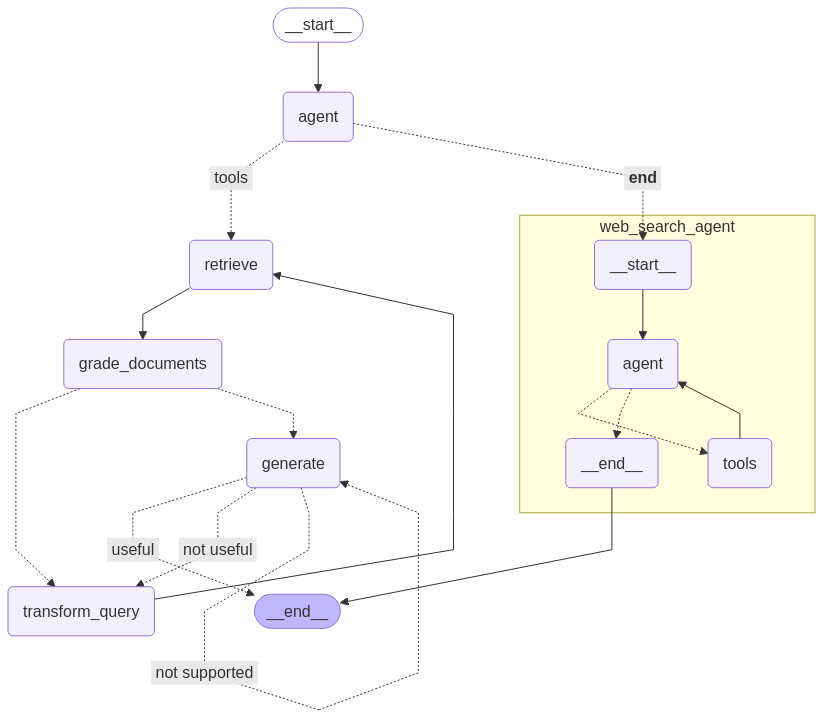

In [ ]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

테스트 !

- `case 1`: 내부 문서 검색이 필요하지 않은 경우

In [20]:
from langgraph.errors import GraphRecursionError

inputs = {
    "messages": "2024년 노벨문학상 수상자는 누구인가요?"
}
try: 
    response = graph.invoke(inputs)
except GraphRecursionError as e:
        print("Recursion Error")

for msg in response["messages"]:
    msg.pretty_print()

##### HI ! #####
response content='2024년 노벨문학상 수상자는 아직 발표되지 않았습니다. 노벨문학상은 매년 10월에 발표되며, 2024년 수상자는 그 시점에 공개될 것입니다. 최신 정보를 확인하려면 노벨상 공식 웹사이트나 관련 뉴스를 참고하시기 바랍니다.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 107, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BXjWr0xT4pe9BN7ttBEchMQV3cCxN', 'finish_reason': 'stop', 'logprobs': None} id='run-f8600971-0d8e-4ad3-8c5f-362265f18b29-0' usage_metadata={'input_tokens': 107, 'output_tokens': 70, 'total_tokens': 177, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
================================ Human Message =================================

2024년 노

- `case 2`: 내부 문서 검색이 필요한 경우

In [21]:
inputs = {
    "messages": "카카오가 개발한 모델에 대해 알려주세요."
}
try: 
    response = graph.invoke(inputs)
except GraphRecursionError as e:
        print("Recursion Error")

for msg in response["messages"]:
    msg.pretty_print()

##### HI ! #####
response content='' additional_kwargs={'tool_calls': [{'id': 'call_28jTq0jIhCglgpx1anKCggrQ', 'function': {'arguments': '{"query":"카카오 모델 개발"}', 'name': 'retrieve_ai_policy_april_2025'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 103, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BXjXYADRZiXtLxFUjc3dNaNcJsp10', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-f21147b8-8aec-4bcd-99cf-bcdd1d1dfeaf-0' tool_calls=[{'name': 'retrieve_ai_policy_april_2025', 'args': {'query': '카카오 모델 개발'}, 'id': 'call_28jTq0jIhCglgpx1anKCggrQ', 'type': 'tool_call'}] usage_metadata={'input_tokens': 103, 'output_tokens': 23, 'total_tokens': 126

c:\Users\pnylo\OneDrive\바탕 화면\Workspace\Langgraph_AIAgent_fastcampus\.conda\Lib\site-packages\langsmith\client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


response content="카카오는 자체 개발한 LLM '카나나(Kanana)'의 테크니컬 리포트를 공개했습니다. 이 모델은 단계별 사전학습, 가지치기, 지식 증류 등의 기법을 통해 학습 효율성을 극대화하였으며, 경량 모델 '카나나 나노 2.1B'를 오픈소스로 제공하고 있습니다. 카나나는 한국어와 영어 성능에서 글로벌 최고 수준을 자랑합니다." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 1077, 'total_tokens': 1181, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BXjXcc5VjyqINMDpsI78NGvNvkyw7', 'finish_reason': 'stop', 'logprobs': None} id='run-0e2fab14-e429-43ef-b022-8a2b8fa481be-0' usage_metadata={'input_tokens': 1077, 'output_tokens': 104, 'total_tokens': 1181, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
##### CHECK HALLUCINATIONS #####
---DECISION: G

In [22]:
inputs = {
    "messages": "마누스 AI 에이전트에 대한 장단점"
}

try: 
    response = graph.invoke(inputs)
except GraphRecursionError as e:
        print("Recursion Error")
        
for msg in response["messages"]:
    msg.pretty_print()

##### HI ! #####
response content='' additional_kwargs={'tool_calls': [{'id': 'call_CCfZ97xjo0SNzscliAKDmf72', 'function': {'arguments': '{"query":"마누스 AI 에이전트 장단점"}', 'name': 'retrieve_ai_policy_april_2025'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 105, 'total_tokens': 135, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BXjYy0eOT4tDGX8LhZD8QbasjJvdu', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-00079c8f-996c-47f8-be47-45fa7000d9aa-0' tool_calls=[{'name': 'retrieve_ai_policy_april_2025', 'args': {'query': '마누스 AI 에이전트 장단점'}, 'id': 'call_CCfZ97xjo0SNzscliAKDmf72', 'type': 'tool_call'}] usage_metadata={'input_tokens': 105, 'output_tokens': 30, 'total_

c:\Users\pnylo\OneDrive\바탕 화면\Workspace\Langgraph_AIAgent_fastcampus\.conda\Lib\site-packages\langsmith\client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


response content='마누스 AI 에이전트의 장점은 인간의 개입 없이 다양한 작업을 독립적으로 수행할 수 있는 완전 자율성입니다. 그러나 초기 테스터들 사이에서 정보 검색 오류와 시스템 다운 등 단점이 지적되고 있으며, 사용자에게 잘못된 답변을 제공하는 경우도 발생하고 있습니다. 이러한 문제에도 불구하고, 정식 출시 전에 시스템 개선이 기대되고 있습니다.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 1048, 'total_tokens': 1139, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BXjZ1d63SYllNJTKoTFqy3OoQTFkR', 'finish_reason': 'stop', 'logprobs': None} id='run-18bc4328-9217-4b12-a723-7e5450b98811-0' usage_metadata={'input_tokens': 1048, 'output_tokens': 91, 'total_tokens': 1139, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
##### CHECK HALLUCINATIONS #####
---DEC

- `case 3`: 부실한 사용자 쿼리를 재작성한 후 재 검색 및 답변

In [23]:
inputs = {
    "messages": "구글 AI AI AI"
}

try: 
    response = graph.invoke(inputs)
except GraphRecursionError as e:
        print("Recursion Error")

for msg in response["messages"]:
    msg.pretty_print()

##### HI ! #####
response content='' additional_kwargs={'tool_calls': [{'id': 'call_LML8pGLbYcnMSWvXOYsQvcIf', 'function': {'arguments': '{"query":"구글 AI"}', 'name': 'retrieve_ai_policy_april_2025'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 97, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BXjZVDHFv2Nn2xvraryW5pJr6Jb5w', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-1699ac3e-2ad2-497e-b524-e9890ad91105-0' tool_calls=[{'name': 'retrieve_ai_policy_april_2025', 'args': {'query': '구글 AI'}, 'id': 'call_LML8pGLbYcnMSWvXOYsQvcIf', 'type': 'tool_call'}] usage_metadata={'input_tokens': 97, 'output_tokens': 22, 'total_tokens': 119, 'input_t

c:\Users\pnylo\OneDrive\바탕 화면\Workspace\Langgraph_AIAgent_fastcampus\.conda\Lib\site-packages\langsmith\client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


response content="구글 딥마인드는 2025년 3월 12일 로봇 제어를 위한 AI 모델 '제미나이 로보틱스'를 공개했습니다. 이 모델은 시각-언어-행동(VLA) 통합 모델로, 물리적 행동을 출력으로 추가하여 다양한 작업을 즉각 수행할 수 있는 범용성을 가지고 있습니다. 또한, '제미나이 로보틱스 -ER' 모델은 물리적 세계에 대한 이해 능력을 향상시켜 로봇 제어에 필요한 모든 추론 단계를 즉시 수행할 수 있습니다." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 132, 'prompt_tokens': 1003, 'total_tokens': 1135, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BXjZYVGf5NBwBZTwoD8IVwQ6uYFYX', 'finish_reason': 'stop', 'logprobs': None} id='run-eadaa847-0376-4f1c-932a-97d0887c27ee-0' usage_metadata={'input_tokens': 1003, 'output_tokens': 132, 'total_tokens': 1135, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
##

c:\Users\pnylo\OneDrive\바탕 화면\Workspace\Langgraph_AIAgent_fastcampus\.conda\Lib\site-packages\langsmith\client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


response content="구글의 인공지능 기술 중 하나인 '제미나이 로보틱스'는 로봇 제어를 위한 시각-언어-행동 모델로, 물리적 행동을 출력으로 추가하여 다양한 작업을 즉각 수행할 수 있는 범용성을 가지고 있습니다. 이 모델은 복잡한 다단계 작업을 수행하고, 환경 변화를 감지하여 즉시 행동을 수정할 수 있는 능력을 갖추고 있습니다. 또한, '제미나이 로보틱스 -ER' 모델은 물리적 세계에 대한 이해를 강화하여 로봇 제어에 필요한 모든 추론 단계를 즉각 수행할 수 있습니다." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 144, 'prompt_tokens': 1015, 'total_tokens': 1159, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a', 'id': 'chatcmpl-BXjZeylWviplLhe1wTZaAHwzTqps6', 'finish_reason': 'stop', 'logprobs': None} id='run-4b529022-e558-44f5-a68f-020b53648a6b-0' usage_metadata={'input_tokens': 1015, 'output_tokens': 144, 'total_tokens': 1159, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {